# 1 Imports

In [2]:
# imports

import os
import re
import json
import math
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from openai import OpenAI

In [3]:
# Call it with Tester.test(function_name, *args)

from testing import Tester

# 2 Connect to OpenAI & HuggingFace

In [4]:
# Load environment variables in a file called .env

load_dotenv()
api_key = os.getenv('OPEN_API_KEY')
openai = OpenAI()

In [5]:
# Load environment variables in a file called .env

load_dotenv()
hf_token = os.getenv('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


# 3 Load Dataset

In [6]:
with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# 4 Fine-Tunning Preparation

## 4.1 Data Selection

In [7]:
fine_tune_train = train[:500]
fine_tune_validation = train[500:1000]

## 4.2 JSONL Preparation

In [8]:
# Create a good prompt for the model

def message_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is $ {item.price:.2f}"}
    ]

In [9]:
print(message_for(train[0]))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'How much does this cost?\n\nAMSUNBO Brand Musical Instruments Crystal Singing Bowl A Note Third Eye Chakra 8 inch with Free Suede Striker and O ring\nBrand AMSUNBO Size 8 inch/ 20cm The Power of Crystal Singing Bowls “ Quartz is a vibrational transmitter” Wilson says. “We’re water . We are a perfect receptor for this kind of information.” Consider how running your finger around the edge of a crystal glass full of water makes it ring and the water itself shift. Because we are about 65–70% water, we react to the sound of the crystal bowls similarly, as their vibration penetrates into us. How to Play Quartz Crystal Singing Bowls Place the AMSUNBO crystal singing bowl symmetrically on its rubber o ring. Run the suede or'}, {'role': 'assistant', 'content': 'Price is $ 89.99'}]


In [10]:
# Convert the items into a list of json objects - 'jsonl' string

def make_jsonl(items):
    result = ''
    for item in items:
        messages = message_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str + '}\n'
    return result.strip()

In [11]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nAMSUNBO Brand Musical Instruments Crystal Singing Bowl A Note Third Eye Chakra 8 inch with Free Suede Striker and O ring\nBrand AMSUNBO Size 8 inch/ 20cm The Power of Crystal Singing Bowls \u201c Quartz is a vibrational transmitter\u201d Wilson says. \u201cWe\u2019re water . We are a perfect receptor for this kind of information.\u201d Consider how running your finger around the edge of a crystal glass full of water makes it ring and the water itself shift. Because we are about 65\u201370% water, we react to the sound of the crystal bowls similarly, as their vibration penetrates into us. How to Play Quartz Crystal Singing Bowls Place the AMSUNBO crystal singing bowl symmetrically on its rubber o ring. Run the suede or"}, {"role": "assistant", "content": "Price is $ 89.99"}]}
{"messages": [{"role": "system", "con

## 4.3 Save JSONL

In [12]:
def write_jsonl(items, filename):
    with open(filename, 'w') as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [13]:
write_jsonl(fine_tune_train, 'fine_tune_train.jsonl')
write_jsonl(fine_tune_validation, 'fine_tune_validation.jsonl')

## 4.4 Load JSONL

In [14]:
with open('fine_tune_train.jsonl', 'rb') as f:
    train_file = openai.files.create(file=f, purpose='fine-tune')

In [15]:
print(train_file)

FileObject(id='file-QPYTfMnFShnb1uwBMyoXhr', bytes=470782, created_at=1744753990, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)


In [16]:
with open('fine_tune_validation.jsonl', 'rb') as f:
    validation_file = openai.files.create(file=f, purpose='fine-tune')

In [17]:
print(validation_file)

FileObject(id='file-WgUFNaPi8L7jmQrCLBWWi3', bytes=466051, created_at=1744753992, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)


# 5 Fine-Tuning

In [18]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model='gpt-4o-mini-2024-07-18',
    seed=42,
    hyperparameters={'n_epochs': 1},
    suffix='pricer'
)

FineTuningJob(id='ftjob-qNnl1CXOzGml8okZgE1QANnm', created_at=1744753994, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-8cYu3pUev8eHFUUPBndE5KXh', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-QPYTfMnFShnb1uwBMyoXhr', validation_file='file-WgUFNaPi8L7jmQrCLBWWi3', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [19]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-qNnl1CXOzGml8okZgE1QANnm', created_at=1744753994, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-8cYu3pUev8eHFUUPBndE5KXh', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-QPYTfMnFShnb1uwBMyoXhr', validation_file='file-WgUFNaPi8L7jmQrCLBWWi3', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)], has_more=True, object='list')

In [20]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [21]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-qNnl1CXOzGml8okZgE1QANnm', created_at=1744753994, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-8cYu3pUev8eHFUUPBndE5KXh', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-QPYTfMnFShnb1uwBMyoXhr', validation_file='file-WgUFNaPi8L7jmQrCLBWWi3', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer', metadata=None)

In [43]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-8rUWwRGVJHN8snVXAFfEcdfp', created_at=1744757710, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-nRUuSF7Z5mJzy8C74LdxKAJZ', created_at=1744757705, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-1rDyXQBjGQZPLTwdXNvtw3pb', created_at=1744757665, level='info', message='Step 500/500: training loss=0.33, validation loss=1.32, full validation loss=0.76', object='fine_tuning.job.event', data={'step': 500, 'train_loss': 0.3327687680721283, 'valid_loss': 1.3226610819498699, 'total_steps': 500, 'full_valid_loss': 0.76091431511773, 'train_mean_token_accuracy': 0.8888888955116272, 'valid_mean_token_accuracy': 0.7777777777777778, 'full_valid_mean_token_accuracy': 0.8373333333333334}, type='metrics'),
 FineTuningJobEvent(id='ftevent-qFoL40dGdQGfZKp4y3AaqFAD', created_at=1

# 6 Prediction with the New Model

In [44]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model
print(fine_tuned_model_name)

ft:gpt-4o-mini-2024-07-18:personal:pricer:BMjTEBKj


In [45]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar", "").replace("\n\nPrice is $", "")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {'role': 'assistant', 'content': f"Price is $ {item.price:.2f}"}
    ]

In [46]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nVic Firth Elementary Education Pack (includes SD1, M5, M14, BSB)\nDesigned to include the correct tools for producing quality sound at the student level, the Vic Firth Education Packs were developed with a step up approach. As the student advances from beginner to intermediate, he or she will acquire the essentials for band and orchestra literature. The EP1 contains a Vic Firth stick bag equipped with a pair of SD1 General Drumsticks, M5 Medium Hard Rubber Mallets, and M14 Poly Head Mallets. Brand Vic Firth Product Code EP1 The EP1 contains a Vic Firth stick bag equipped with a pair of SD1 General Drumsticks, M5 Medium Hard Rubber Mallets, and M14 Poly Head Mallets Weight 1 pounds,'},
 {'role': 'assistant', 'content': 'Price is $ 59.99'}]

In [47]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [48]:
get_price('The price is roughly $ 123.45')

123.45

In [49]:
# Call the fine-tuned model
def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [50]:
print(test[0].price, gpt_fine_tuned(test[0]))

59.99 22.5


1: Guess: $22.50 Truth: $59.99 Error: $37.49 SLE: 0.91 Item: Vic Firth Elementary Education Pack (inc...
2: Guess: $88.73 Truth: $88.73 Error: $0.00 SLE: 0.00 Item: Samson Q6 Dynamic Microphone 3-Pack, Bla...
3: Guess: $26.65 Truth: $26.59 Error: $0.06 SLE: 0.00 Item: Buckle-Down Guitar Strap Unicorn Univers...
4: Guess: $112.95 Truth: $113.40 Error: $0.45 SLE: 0.00 Item: Kluson Revolution Tuners 3x3 No Collar L...
5: Guess: $60.99 Truth: $60.99 Error: $0.00 SLE: 0.00 Item: EBXYA 1/4 TRS to XLR Male 6.5ft 6 Color ...
6: Guess: $22.99 Truth: $19.99 Error: $3.00 SLE: 0.02 Item: Tesi IDO Super M 10mm Stainless Steel Ki...
7: Guess: $23.47 Truth: $21.23 Error: $2.24 SLE: 0.01 Item: ICEPURE 5231JA2002A Refrigerator Water F...
8: Guess: $0.00 Truth: $5.99 Error: $5.99 SLE: 3.78 Item: Kmise Round Head Strap Locks Straplocks ...
9: Guess: $3.99 Truth: $3.99 Error: $0.00 SLE: 0.00 Item: FUPEI 9 Pcs Maple Syrup 1 Quart Filter S...
10: Guess: $80.00 Truth: $80.00 Error: $0.00 SLE: 0.00 Item: Lfhe

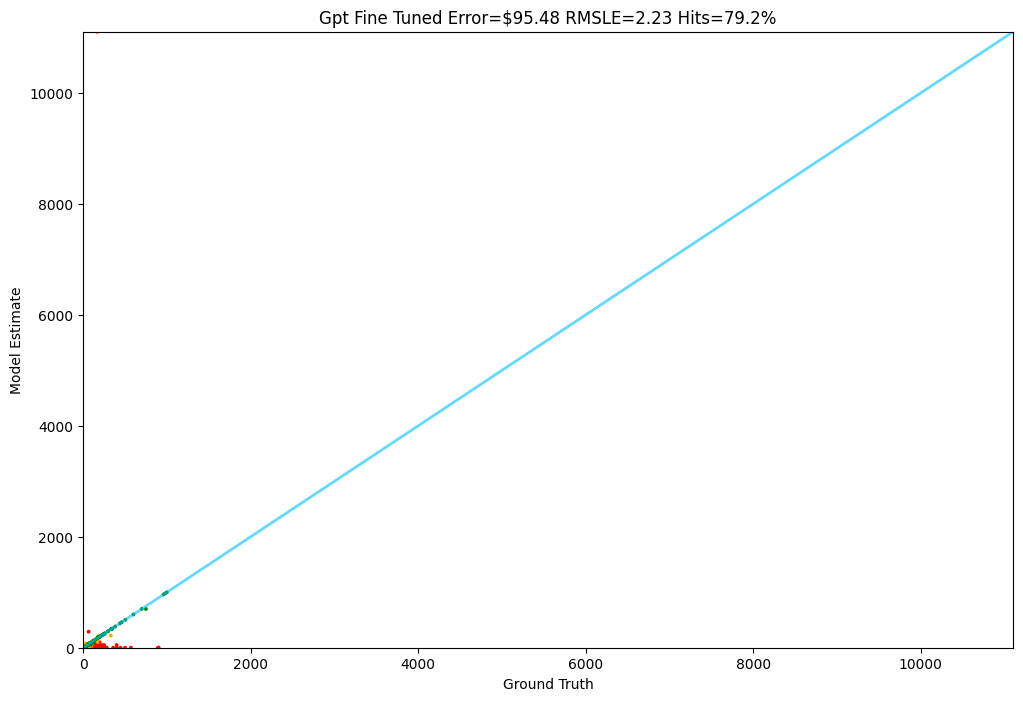

In [51]:
Tester.test(gpt_fine_tuned, test)